In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-22 06:36:42--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-05-22 06:36:43 (7.96 MB/s) - 'names.txt' saved [228145/228145]



Loading Corpus

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Populating Vocabulary

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

Bulding Dataset

In [6]:
block_size = 3 # context_length

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [7]:
import random

In [8]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP

In [9]:
# MLP Revisited
n_embd = 10 # the dimensionality of the dense char embedding vector
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g)*0.00
W2 = torch.randn((vocab_size, n_hidden), generator = g).T * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0.00

### Batch Normalisaiton

In [10]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

### Motivation for correct normalising constants

tensor(-0.0003) tensor(1.0189)
tensor(0.0125) tensor(3.1209)


(array([1.37566450e-05, 0.00000000e+00, 2.06349675e-05, 1.37566450e-05,
        7.56615476e-05, 9.62965151e-05, 1.10053160e-04, 2.75132900e-04,
        3.43916126e-04, 6.39683993e-04, 9.42330184e-04, 1.82275547e-03,
        3.04021855e-03, 4.69789427e-03, 7.28414354e-03, 1.22984406e-02,
        1.85233225e-02, 2.82699055e-02, 3.96535293e-02, 5.60858418e-02,
        7.39969936e-02, 9.37996841e-02, 1.13960047e-01, 1.29842094e-01,
        1.35819356e-01, 1.34457448e-01, 1.23094460e-01, 1.05458441e-01,
        8.46927851e-02, 6.43673421e-02, 4.69514295e-02, 3.31741495e-02,
        2.22513733e-02, 1.49122032e-02, 9.48520674e-03, 5.97038394e-03,
        3.60424100e-03, 2.24921146e-03, 1.22434141e-03, 8.87303604e-04,
        6.05292381e-04, 2.82011223e-04, 1.30688128e-04, 1.30688128e-04,
        5.50265801e-05, 2.06349675e-05, 6.87832251e-06, 6.87832251e-06,
        1.37566450e-05, 6.87832251e-06]),
 array([-17.97420502, -17.24728359, -16.52036217, -15.79344074,
        -15.06651932, -14.3395

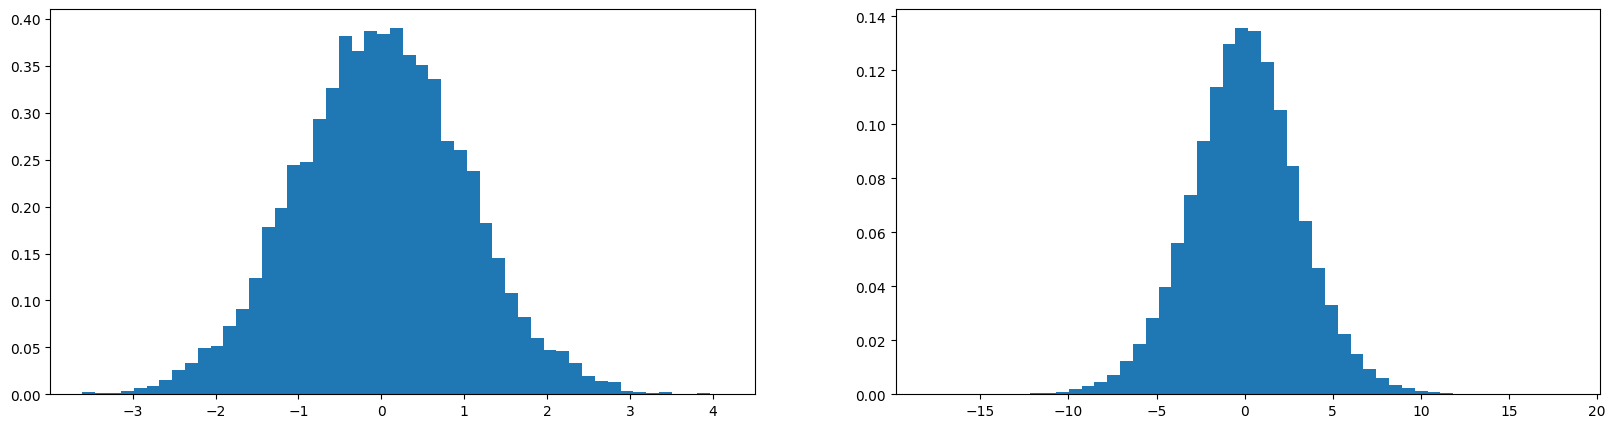

In [11]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

Mean remains the same, but std div has expanded, but we dont want that \
so we must scale w, correctly suchthat it preserves the gaussian \
Mathematically comes out to be divided by the squareroot of fan in, that is shape[0]
```
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
```

Most people use the inbuild `kaiming_normalisation` 

and we also need a gain included in this std normalisation as tanh is a contractive activation

### Preparing for grad

In [12]:
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Normalisation
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2944
  10000/ 200000: 2.1204
  20000/ 200000: 2.6738
  30000/ 200000: 1.9978
  40000/ 200000: 2.2211
  50000/ 200000: 1.8527
  60000/ 200000: 2.0737
  70000/ 200000: 2.2758
  80000/ 200000: 2.3699
  90000/ 200000: 2.1287
 100000/ 200000: 2.2205
 110000/ 200000: 2.4661
 120000/ 200000: 1.7136
 130000/ 200000: 2.0199
 140000/ 200000: 2.1848
 150000/ 200000: 1.9880
 160000/ 200000: 2.0510
 170000/ 200000: 2.4521
 180000/ 200000: 2.1227
 190000/ 200000: 2.1528


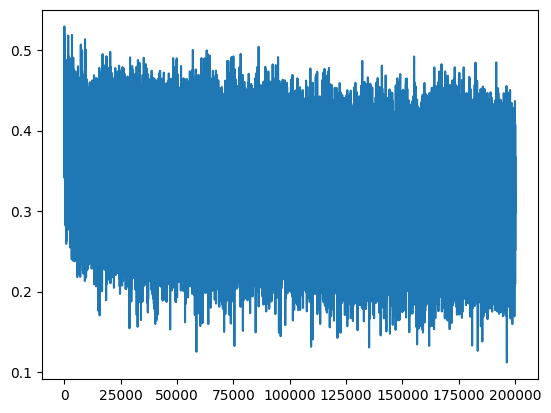

In [14]:
plt.plot(lossi)

In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte}
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact =  bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0679590702056885
val 2.1088221073150635


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0]*block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1) # + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decodeand print the generated word

briah.
myazlieenmilynn.
sabellascengrlot.
shelydanliths.
girenleyegssandalissathi.
shqayce.
shub.
roxhiriestin.
joxcelshnnicolfsubfatvenshyldur.
els.
gianghstlyanshinshalyanshupubialventen.
try.
bronaoellafrdin.
brookobh.
gicibroretty.
brhun.
bluisaqiifelvondwriah.
xtharshzthed.
silvissif.
fadvissivliviennakelandiyaxabiguhmi.


In [18]:
# SUMMARY + PYTORCHIFYING

## Linear

In [19]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_out, fan_in), generator=g) / fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = self.W @ x
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


In [20]:
layer = Linear(3, 4)
layer.parameters()

[tensor([[ 0.8310, -0.4146, -0.1519],
         [-0.0970, -0.0788, -0.2030],
         [-0.1612, -0.3206, -0.3687],
         [ 1.0440, -0.0957,  0.5926]]),
 tensor([0., 0., 0., 0.])]

In [21]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim, 1) # bngain
        self.beta = torch.zeros(dim, 1) # bnbias
        # buffers (trined with a running 'momentum update')
        self.running_mean = torch.zeros(dim, 1)
        self.running_var = torch.ones(dim, 1)
    
    def __call__(self, x):
        # here x, is h_preactivation
        # calulate the forward pass
        if self.training:
            xmean = x.mean(1, keepdims = True) # batch mean
            xvar = x.var(1, keepdims = True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum* xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [22]:
# With Learnable Parameters
m = BatchNorm1d(100)
input = torch.randn(100, 20)
output = m(input)
output

tensor([[-0.5877,  0.8887,  1.0485,  ..., -0.7074, -2.0020,  0.1564],
        [ 0.2648, -1.5651,  1.4902,  ...,  0.2208,  1.5731,  1.7757],
        [-1.0745, -0.4019, -0.2928,  ..., -0.3801, -0.4971,  1.3683],
        ...,
        [-1.2359,  1.0063, -1.7816,  ...,  0.7177,  0.7206, -0.4510],
        [ 0.7014,  0.5066,  0.9162,  ...,  0.6142, -0.1294, -1.1612],
        [-0.4888, -0.5392,  0.2446,  ..., -0.9677, -1.2485, -0.8312]])

## Building MLP

In [23]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd*block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size),
]

In [24]:
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

In [25]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [26]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embedding chars
    x = emb.view(-1, emb.shape[0]) 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x.T, Yb)
    
    # backward pass 
    for layer in layers:
        layer.out.retain_grad() # for graphing
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2968
  10000/ 200000: 3.0016
  20000/ 200000: 2.7556
  30000/ 200000: 2.5882
  40000/ 200000: 2.8011
  50000/ 200000: 2.7648
  60000/ 200000: 2.7602
  70000/ 200000: 2.8342
  80000/ 200000: 2.9691
  90000/ 200000: 2.9848
 100000/ 200000: 2.8329
 110000/ 200000: 2.8739
 120000/ 200000: 2.8820
 130000/ 200000: 2.5756
 140000/ 200000: 2.5388
 150000/ 200000: 2.6295
 160000/ 200000: 3.0810
 170000/ 200000: 2.7404
 180000/ 200000: 2.8966
 190000/ 200000: 2.6775


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.56%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.81%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%


Text(0.5, 1.0, 'activation distribution')

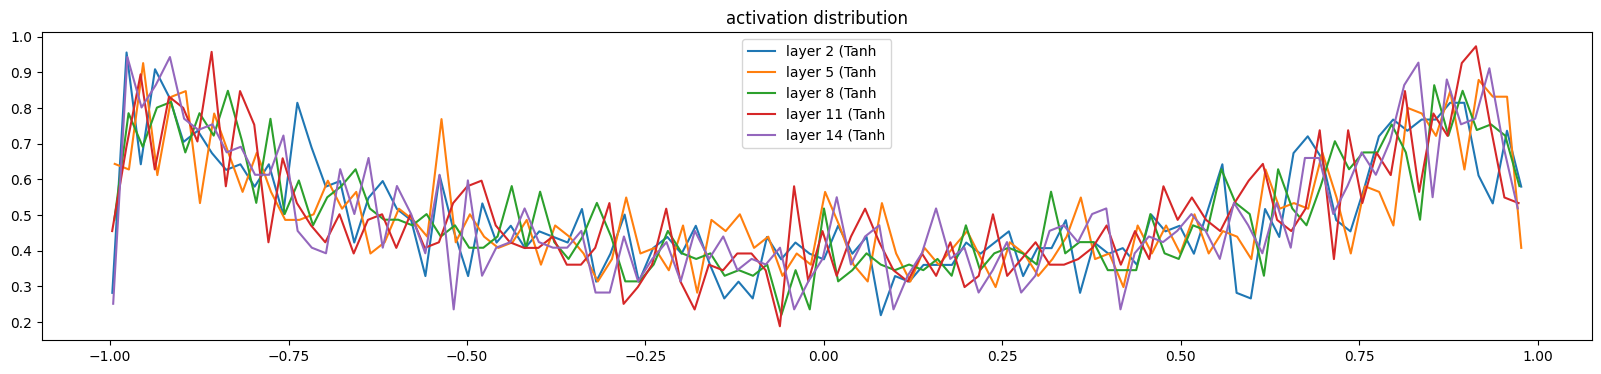

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.575188e-04
layer 5 (      Tanh): mean +0.000000, std 2.733386e-04
layer 8 (      Tanh): mean -0.000000, std 2.085164e-04
layer 11 (      Tanh): mean -0.000000, std 1.751094e-04
layer 14 (      Tanh): mean -0.000000, std 1.651528e-04


Text(0.5, 1.0, 'gradient distribution')

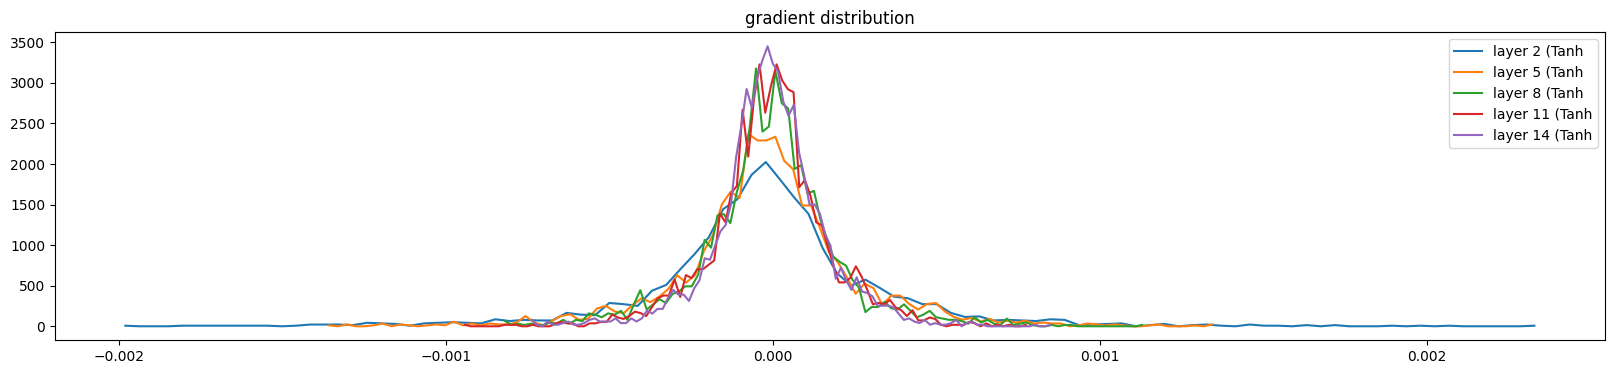

In [28]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.012318e-03 | grad:data ratio 1.011231e-03
weight  (100, 30) | mean +0.000005 | std 8.785822e-04 | grad:data ratio 2.808833e-03
weight   (100, 1) | mean +0.000071 | std 7.432300e-04 | grad:data ratio 2.891744e-02
weight   (100, 1) | mean -0.000022 | std 6.198219e-04 | grad:data ratio 1.310211e-02
weight (100, 100) | mean -0.000000 | std 6.731444e-04 | grad:data ratio 4.022333e-03
weight   (100, 1) | mean +0.000012 | std 5.279231e-04 | grad:data ratio 3.263501e-02
weight   (100, 1) | mean +0.000031 | std 4.392769e-04 | grad:data ratio 1.719432e-02
weight (100, 100) | mean -0.000002 | std 4.930407e-04 | grad:data ratio 2.922404e-03
weight   (100, 1) | mean +0.000027 | std 3.816013e-04 | grad:data ratio 2.229508e-02
weight   (100, 1) | mean +0.000007 | std 4.501741e-04 | grad:data ratio 2.052380e-02
weight (100, 100) | mean -0.000000 | std 4.032727e-04 | grad:data ratio 2.403047e-03
weight   (100, 1) | mean +0.000006 | std 3.042736e-04 | grad:data

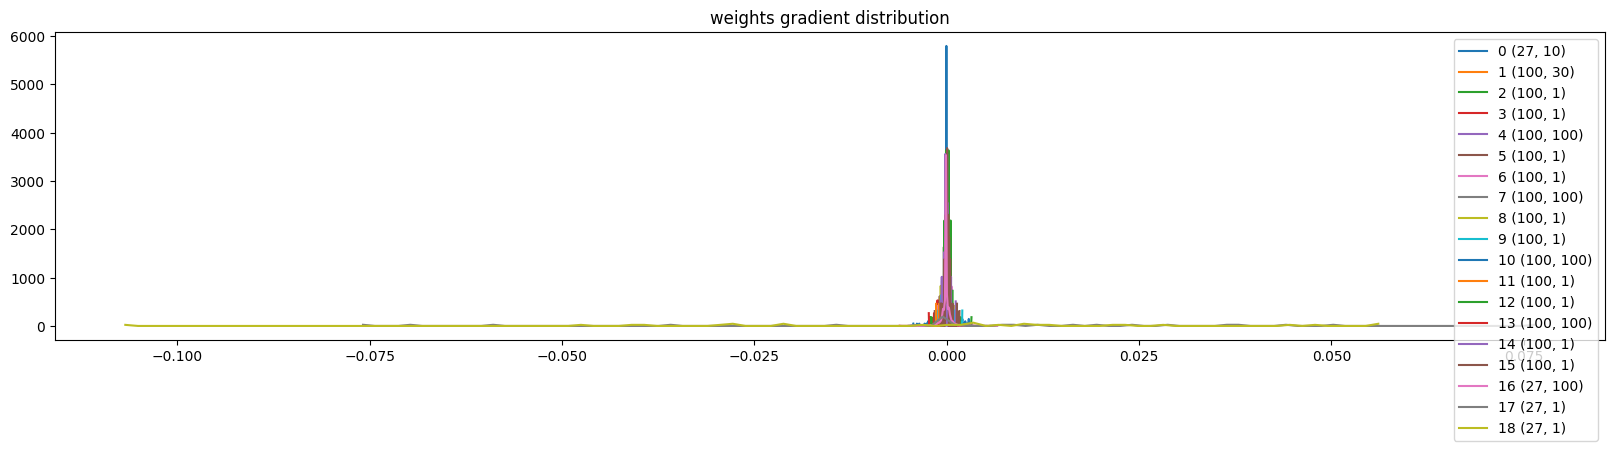

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


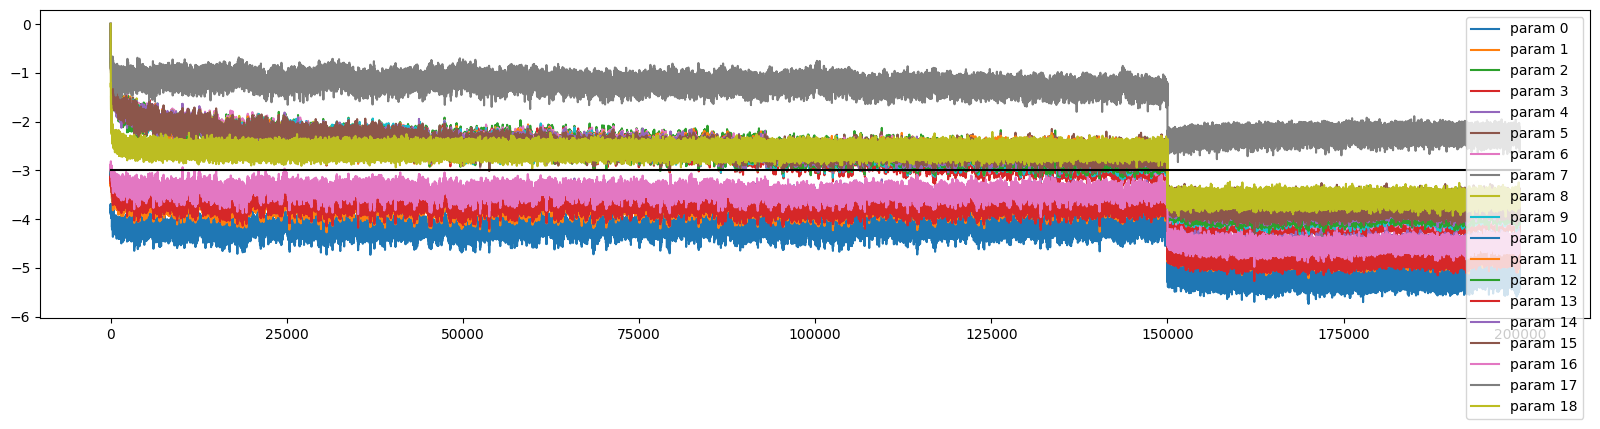

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  
  x = emb.view(-1, emb.shape[0]) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x.T, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.8246171474456787
val 2.8219070434570312


In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(-1, emb.shape[0]) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1).T
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

erbuagmyazzhzevvndhfyaloqetvrsjejdrljg.
ozcjedgeliihsmpqppalekeixvqnwxarqeptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufzehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqyxoeobhggptixjsfcueywhkhmreolbiilqiif.
wvpkxwvlla.
ortabfsztjndgoizvsblitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudt.
iwbddihzvorlq.
cjakepxugniagcrpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkzdcqbcep.
ccdfivsnipimhtecmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosy.
sj.
ascnpc.
cilwtanczhndtebimm.
